<a href="https://colab.research.google.com/github/ManuSinghYadav/Andrej_Karpathy_Zero_to_Hero/blob/main/Makemore_series_Lecture_3_(Activations_%26_BN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
words_ = ['...' + w + '.' for w in words]
words_[:10]

['...emma.',
 '...olivia.',
 '...ava.',
 '...isabella.',
 '...sophia.',
 '...charlotte.',
 '...mia.',
 '...amelia.',
 '...harper.',
 '...evelyn.']

In [ ]:
# @title Old dataset building
# build the dataset

X, Y = [], []
for w in words: # Iterate through the first 5 words
  # Add padding to the beginning and end of each word
  w_padded = '...' + w + '.'
  for i in range(len(w_padded) - 3): # Iterate through the padded word to create 3-character inputs and 1-character targets
    X.append([stoi[w_padded[i]], stoi[w_padded[i+1]], stoi[w_padded[i+2]]])
    Y.append(stoi[w_padded[i+3]])

X, Y = torch.tensor(X), torch.tensor(Y)

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])




nn (1).svg



###Whole NN


In [ ]:
n_embd = 10
n_hidden = 200
vocab_size = len(itos)

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g) #* 0
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #Kaiming init (normal)
# b1 = torch.randn(n_hidden,                        generator=g) * 0 (Removing it since in bn it is getting substracted, so no use)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1 , W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 10000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1

  # batch normalization
  hpreact = (bngain*(hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) ) + bnbias

  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

  # break

      0/  10000: 3.3239
   1000/  10000: 2.4625
   2000/  10000: 2.3618
   3000/  10000: 2.1614
   4000/  10000: 1.9959
   5000/  10000: 2.0971
   6000/  10000: 2.1198
   7000/  10000: 2.3366
   8000/  10000: 1.8021
   9000/  10000: 2.4943


(array([205., 181., 189., 164., 147., 151., 147., 132., 132., 127., 109.,
        106., 101., 117., 115., 103., 123., 116., 134.,  98., 106., 101.,
         90., 111., 100., 122., 109., 101., 107.,  99.,  92., 123.,  95.,
        117., 109., 109., 147., 134., 103., 105., 123., 118., 143., 138.,
        156., 146., 159., 161., 189., 190.]),
 array([-9.98713732e-01, -9.58751193e-01, -9.18788655e-01, -8.78826116e-01,
        -8.38863578e-01, -7.98901039e-01, -7.58938501e-01, -7.18975962e-01,
        -6.79013424e-01, -6.39050885e-01, -5.99088347e-01, -5.59125808e-01,
        -5.19163270e-01, -4.79200732e-01, -4.39238193e-01, -3.99275655e-01,
        -3.59313116e-01, -3.19350578e-01, -2.79388039e-01, -2.39425501e-01,
        -1.99462962e-01, -1.59500424e-01, -1.19537885e-01, -7.95753467e-02,
        -3.96128082e-02,  3.49730253e-04,  4.03122687e-02,  8.02748072e-02,
         1.20237346e-01,  1.60199884e-01,  2.00162423e-01,  2.40124961e-01,
         2.80087500e-01,  3.20050038e-01,  3.60012

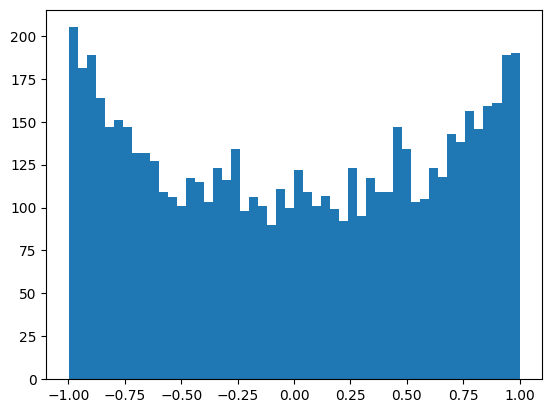

In [ ]:
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   1.,   2.,   6.,   6.,  13.,  11.,  25.,  29.,  40.,  52.,
         58.,  90., 120., 137., 165., 201., 242., 300., 290., 333., 405.,
        395., 407., 400., 371., 395., 316., 280., 271., 222., 180., 135.,
        121.,  94.,  74.,  57.,  53.,  26.,  29.,  15.,  10.,   6.,   8.,
          2.,   2.,   1.,   1.,   0.,   1.]),
 array([-3.67424893, -3.51942758, -3.36460623, -3.20978487, -3.05496352,
        -2.90014217, -2.74532082, -2.59049946, -2.43567811, -2.28085676,
        -2.1260354 , -1.97121405, -1.8163927 , -1.66157135, -1.50674999,
        -1.35192864, -1.19710729, -1.04228593, -0.88746458, -0.73264323,
        -0.57782187, -0.42300052, -0.26817917, -0.11335782,  0.04146354,
         0.19628489,  0.35110624,  0.5059276 ,  0.66074895,  0.8155703 ,
         0.97039165,  1.12521301,  1.28003436,  1.43485571,  1.58967707,
         1.74449842,  1.89931977,  2.05414113,  2.20896248,  2.36378383,
         2.51860518,  2.67342654,  2.82824789,  2.98306924,  3.1378906 ,
 

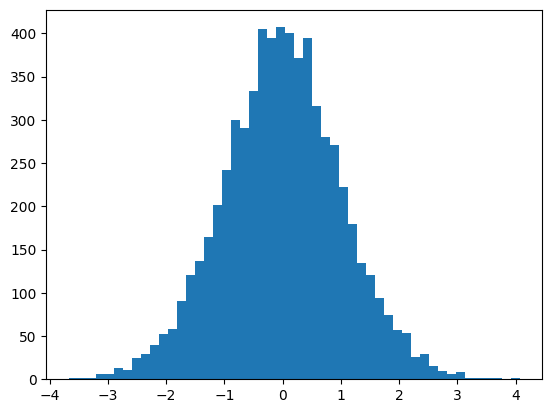

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [ ]:
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  emb = emb.view(-1, n_embd * 3)
  hpreact = (emb @ W1) #+ b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = (h @ W2) + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  # return loss.item()

split_loss('train')
split_loss('val')

train 2.7453360557556152
val 2.742286205291748


In [ ]:
logits = torch.zeros(27)
probs = F.softmax(logits, dim=0)
print(f'Logits {logits}')
print(f'probs {probs}')
loss = -torch.log(probs[3]) # NLL (F.cross_entropy(logits, torch.tensor(3)))
print(f'loss {loss:4f}')

Logits tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
probs tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])
loss 3.295837


In [ ]:
w = torch.randn((n_embd * block_size, n_hidden), generator=g)
w.mean(), w.std()

(tensor(-0.0010), tensor(1.0076))

In [ ]:
x = torch.randn(100, 6, generator = g )
(x).std()

tensor(1.0160)

In [ ]:
embcat.shape, W1.shape, hpreact.shape

(torch.Size([32, 30]), torch.Size([30, 200]), torch.Size([32, 200]))

In [ ]:
hpreact

tensor([[-0.4438, -1.0219, -0.9979,  ...,  1.1585,  0.4043, -1.2533],
        [-1.8619,  1.1925, -0.4266,  ...,  1.4576, -1.0703,  0.2600],
        [-0.7934, -0.0891,  0.0989,  ...,  1.7210, -1.6242, -0.0909],
        ...,
        [-0.5175, -0.1962,  1.6034,  ..., -0.3202,  1.0564,  0.8732],
        [ 1.7521, -1.4048,  0.9828,  ..., -2.0949, -0.4899, -0.6977],
        [ 1.2857, -1.8922,  1.5731,  ..., -0.3683,  0.0945,  0.6735]],
       grad_fn=<AddBackward0>)

In [ ]:
hpreact[0]

tensor([-0.4438, -1.0219, -0.9979, -0.9275,  1.4807,  1.5713, -0.8873,  0.4873,
        -1.2761, -1.0303, -1.0146,  0.9976,  1.5367, -0.9380,  0.5258, -0.4323,
        -0.0632,  0.0516, -1.6170,  2.7918,  0.8479, -1.3710,  0.6593, -0.1178,
         0.9678, -1.3869, -0.4347,  0.3961,  1.2036,  0.0517, -0.7364,  0.0618,
        -1.9277, -1.1923, -0.4830,  1.1337, -1.3347, -0.0151, -0.9862,  0.2620,
         0.0899, -1.4413,  0.5053, -0.5171, -0.5416, -0.7127, -0.7489, -1.0970,
         2.1146,  0.8236,  1.3950,  0.5522,  1.5538,  0.5162,  2.0964, -0.5169,
         0.2480,  1.9533,  0.7319,  1.4556, -1.6002, -0.9275,  2.0926, -0.1169,
         3.3970,  1.2884, -0.3420,  0.6576, -0.9657,  0.1461, -1.3519,  1.1908,
         2.2577, -1.0067, -2.2745, -1.0617, -0.4580, -1.0341, -2.3091, -0.3005,
        -0.9963,  1.2447,  0.9715, -0.0229, -0.9485, -0.9950,  2.3943,  0.3040,
         1.2033, -0.5935,  3.0227, -0.8261,  0.5102, -1.7178, -0.7378, -2.8724,
        -0.5068, -1.2162, -0.2530,  1.94

In [ ]:
hpreact[0].mean(), hpreact[0].std()

(tensor(0.0644, grad_fn=<MeanBackward0>),
 tensor(1.2139, grad_fn=<StdBackward0>))

In [ ]:
hpreact.mean(0, keepdim=True)[0]

tensor([ 0.1054, -0.1160,  0.0877, -0.1213, -0.0311, -0.0328,  0.0601, -0.0369,
         0.2539,  0.2181,  0.3416,  0.2349, -0.0358,  0.0913, -0.1128, -0.0400,
         0.2578,  0.1088, -0.2834,  0.5673, -0.0428, -0.0762,  0.0630, -0.0472,
         0.0586,  0.1395,  0.1123, -0.2667,  0.0746,  0.0744,  0.0364,  0.0413,
        -0.0174, -0.1100,  0.1822, -0.1425,  0.6621,  0.1344, -0.2643, -0.0055,
        -0.1405,  0.0937, -0.0959, -0.0656,  0.2320,  0.0434, -0.1748,  0.0252,
        -0.1380, -0.4585,  0.0086, -0.0841, -0.1900, -0.1480, -0.3853,  0.2036,
        -0.0496,  0.2725, -0.1477,  0.1576, -0.0059,  0.0727,  0.0889, -0.0257,
         0.1823,  0.2538, -0.0697, -0.1008,  0.0871,  0.1007,  0.0607, -0.3115,
         0.1397,  0.0985, -0.0046, -0.1127,  0.0650, -0.1598, -0.1320, -0.3100,
        -0.2051,  0.0068,  0.1901, -0.3850, -0.1553, -0.1969,  0.2259, -0.0574,
        -0.4195,  0.1465, -0.1562,  0.1911,  0.0118,  0.0624, -0.1617, -0.0764,
         0.3253,  0.0992,  0.2076, -0.22

In [ ]:
hpreact.std(0, keepdim=True)[0].shape

torch.Size([200])

In [ ]:
bn = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)

In [ ]:
# 10 batches, with 10 inputs
hpreact = torch.arange(1, 101).view(10,-1)
hpreact

tensor([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10],
        [ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20],
        [ 21,  22,  23,  24,  25,  26,  27,  28,  29,  30],
        [ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40],
        [ 41,  42,  43,  44,  45,  46,  47,  48,  49,  50],
        [ 51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
        [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70],
        [ 71,  72,  73,  74,  75,  76,  77,  78,  79,  80],
        [ 81,  82,  83,  84,  85,  86,  87,  88,  89,  90],
        [ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100]])

In [ ]:
hpreact.sum(0, keepdim=True)

tensor([[460, 470, 480, 490, 500, 510, 520, 530, 540, 550]])

In [ ]:
a = torch.arange(6400).view(32,-1)
a.shape

torch.Size([32, 200])

In [ ]:
# (32, 200) @ (200, 200)

In [ ]:
C  = torch.randn((vocab_size, n_embd),            generator=g) #* 0
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #Kaiming init (normal)


In [ ]:
x = torch.randn(2, 10, generator = g)
w = torch.randn((10, 3), generator = g)

In [ ]:
x @ w # (2, 10) @ (10, 3)

tensor([[ -6.9010,   3.1122, -10.0675],
        [ -1.0486,   3.0691,   6.1641]])